In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout
from keras.models import Model,Sequential
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,RMSprop,SGD
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
img_width, img_height = 128,128

In [3]:
train_files = glob.glob('data/flower_photos/daisy/*.jpg')
x_train_list = []


for file in train_files:
    img = cv2.imread(file)
    img = cv2.resize(img,(img_width,img_height))
    x_train_list.append(img)


x_train = np.asarray(x_train_list)
x_train.shape

(633, 128, 128, 3)

In [4]:
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_train.shape

(633, 128, 128, 3)

In [7]:
#this one is on keras blog
autoencoder = Sequential()

autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 3)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

autoencoder.add(Flatten(name = 'f'))

autoencoder.add(Reshape((16, 16, 8)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding = "same"))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('f').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
f (Flatten)                  (None, 2048)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 8)         0         
__________

In [8]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'] )
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
              validation_split = 0.2,callbacks=[TensorBoard(log_dir='../logs/',histogram_freq=1, write_graph=False, write_images=False)]
                )

Train on 506 samples, validate on 127 samples
Epoch 1/50
506/506 [==============================] - 9s 18ms/step - loss: 0.6910 - acc: 0.0283 - val_loss: 0.6890 - val_acc: 0.0272
Epoch 2/50
506/506 [==============================] - 1s 2ms/step - loss: 0.6884 - acc: 0.0307 - val_loss: 0.6858 - val_acc: 0.0279
Epoch 3/50
506/506 [==============================] - 1s 2ms/step - loss: 0.6852 - acc: 0.0323 - val_loss: 0.6806 - val_acc: 0.0307
Epoch 4/50
506/506 [==============================] - 1s 2ms/step - loss: 0.6784 - acc: 0.0365 - val_loss: 0.6688 - val_acc: 0.0345
Epoch 5/50
506/506 [==============================] - 1s 2ms/step - loss: 0.6673 - acc: 0.0395 - val_loss: 0.6399 - val_acc: 0.0362
Epoch 6/50
506/506 [==============================] - 1s 2ms/step - loss: 0.6509 - acc: 0.0392 - val_loss: 0.6389 - val_acc: 0.0358
Epoch 7/50
506/506 [==============================] - 1s 2ms/step - loss: 0.6170 - acc: 0.0395 - val_loss: 0.5884 - val_acc: 0.0365
Epoch 8/50
506/506 [=========

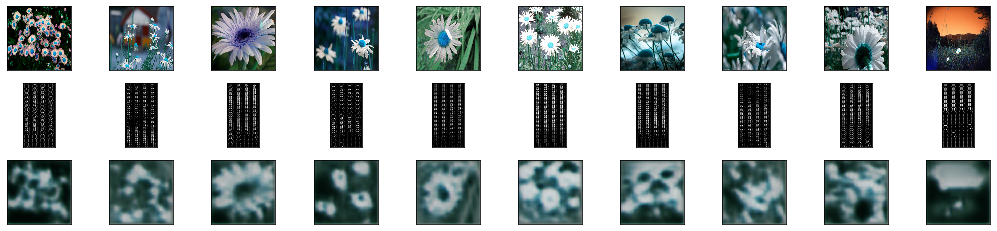

In [9]:
#this snippet is from https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/
x_test = x_train
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(img_width, img_height, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(64, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(img_width, img_height,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



In [5]:
#this structure I found somewhere in kaggle

autoencoder = Sequential()

autoencoder.add(Conv2D(16, (3, 3), activation='elu', padding='same',input_shape=(img_width, img_height, 3)))
autoencoder.add(Conv2D(16, (3, 3), activation='elu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
autoencoder.add( MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same', name="encoded"))

autoencoder.add(Flatten(name = 'f'))

autoencoder.add(Reshape((8, 8, 128)))

autoencoder.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
autoencoder.add(Dropout(0.3)) 
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
autoencoder.add(Dropout(0.3)) 
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoder.add( Dropout(0.3))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add( Conv2D(16, (3, 3), activation='elu', padding='same') )
autoencoder.add( Conv2D(16, (3, 3), activation='elu', padding = 'same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (2, 2), activation='sigmoid', padding='same',name="decoded"))


autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('f').output)
autoencoder.summary()
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
__________

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'] )
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
              validation_split = 0.2,callbacks=[TensorBoard(log_dir='../logs/',histogram_freq=1, write_graph=False, write_images=False)]
                )

Train on 506 samples, validate on 127 samples
Epoch 1/50
506/506 [==============================] - 11s 22ms/step - loss: 0.6981 - acc: 0.0268 - val_loss: 0.6816 - val_acc: 0.0350
Epoch 2/50
506/506 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.0327 - val_loss: 0.6847 - val_acc: 0.0325
Epoch 3/50
506/506 [==============================] - 2s 4ms/step - loss: 0.6808 - acc: 0.0336 - val_loss: 0.6675 - val_acc: 0.0354
Epoch 4/50
506/506 [==============================] - 2s 4ms/step - loss: 0.7344 - acc: 0.0350 - val_loss: 0.6716 - val_acc: 0.0353
Epoch 5/50
506/506 [==============================] - 2s 4ms/step - loss: 0.6704 - acc: 0.0361 - val_loss: 0.6472 - val_acc: 0.0352
Epoch 6/50
506/506 [==============================] - 2s 4ms/step - loss: 0.6877 - acc: 0.0359 - val_loss: 0.6677 - val_acc: 0.0353
Epoch 7/50
506/506 [==============================] - 2s 4ms/step - loss: 0.6598 - acc: 0.0373 - val_loss: 0.6125 - val_acc: 0.0358
Epoch 8/50
506/506 [========

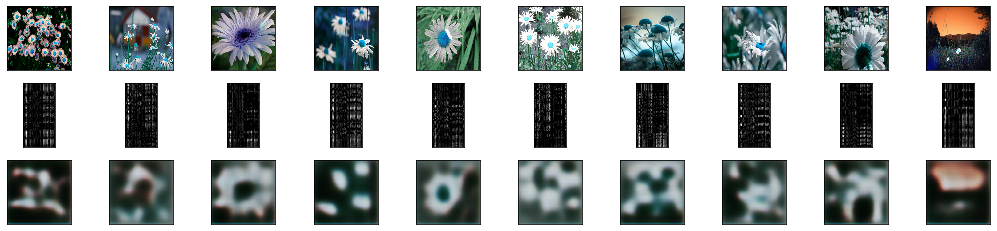

In [8]:
#this snippet is from https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/

x_test = x_train
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(img_width, img_height, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(128, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(img_width, img_height,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

